# Value

In [ ]:
# | default_exp core.value

In [ ]:
#|export
from fastcore.test import *
from graphviz import Digraph
import math

In [ ]:
#|export
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: 1
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        val = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(val, (self,), "tanh")
        def _backward():
            self.grad += (1 - val**2) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (other * -1)

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1

    def backward(self):
        visited = set()
        topo_order = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo_order.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo_order):
            v._backward()
        



In [ ]:
assert (Value(1) + Value(2)).data == (Value(3)).data
assert (Value(1) * Value(2)).data == (Value(2)).data
assert (Value(1) + Value(2) * Value(3)).data == (Value(7)).data

In [ ]:
#| export

def trace(root):
    # builds a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"label: {n.label} | data: {n.data} | grad: {n.grad}", shape="record")
        if n._op:
            dot.node(name=f"op_{uid}", label=n._op)
            dot.edge(f"op_{uid}", uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), f"op_{str(id(n2))}")
    return dot

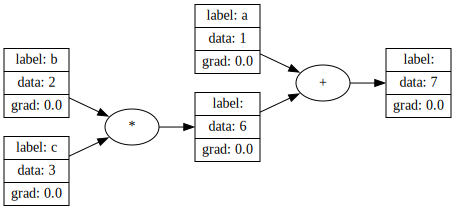

In [ ]:
draw_dot(Value(1, label='a') + Value(2, label='b') * Value(3, label='c'))

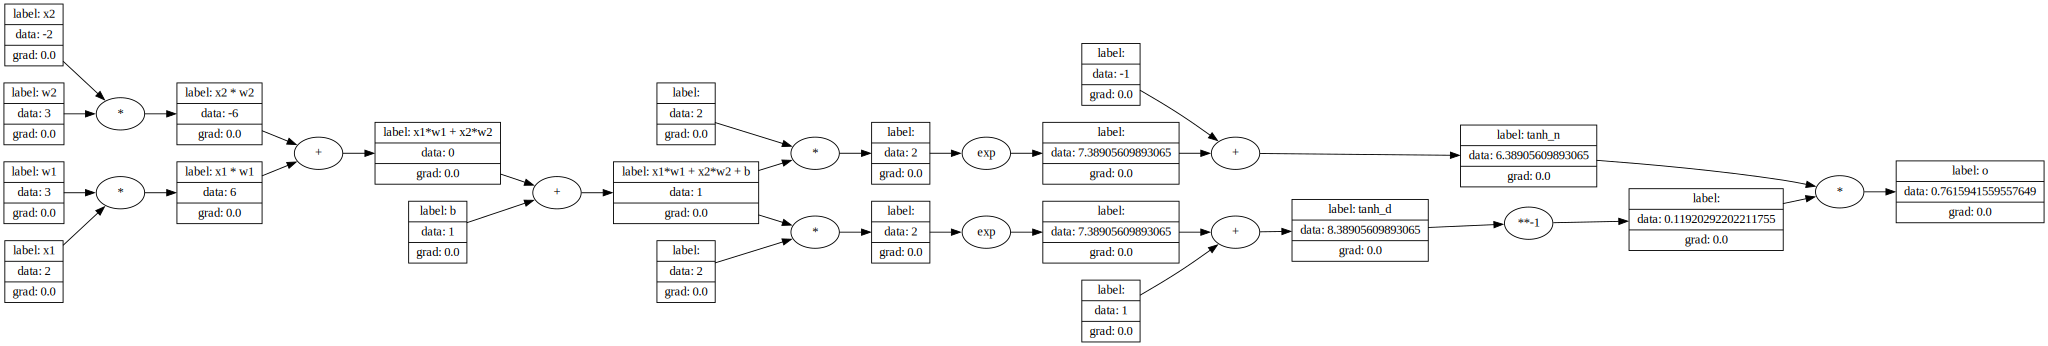

In [ ]:
x1 = Value(2, label='x1')
x2 = Value(-2, label='x2')
w1 = Value(3, label='w1')
w2 = Value(3, label='w2')
b = Value(1, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
x1w1_x2w2_b = x1w1_x2w2 + b; x1w1_x2w2_b.label = 'x1*w1 + x2*w2 + b'
tanh_n = (x1w1_x2w2_b * 2).exp() - 1; tanh_n.label = 'tanh_n'
tanh_d = (x1w1_x2w2_b * 2).exp() + 1; tanh_d.label = 'tanh_d'
o = tanh_n / tanh_d; o.label = 'o'
draw_dot(o)

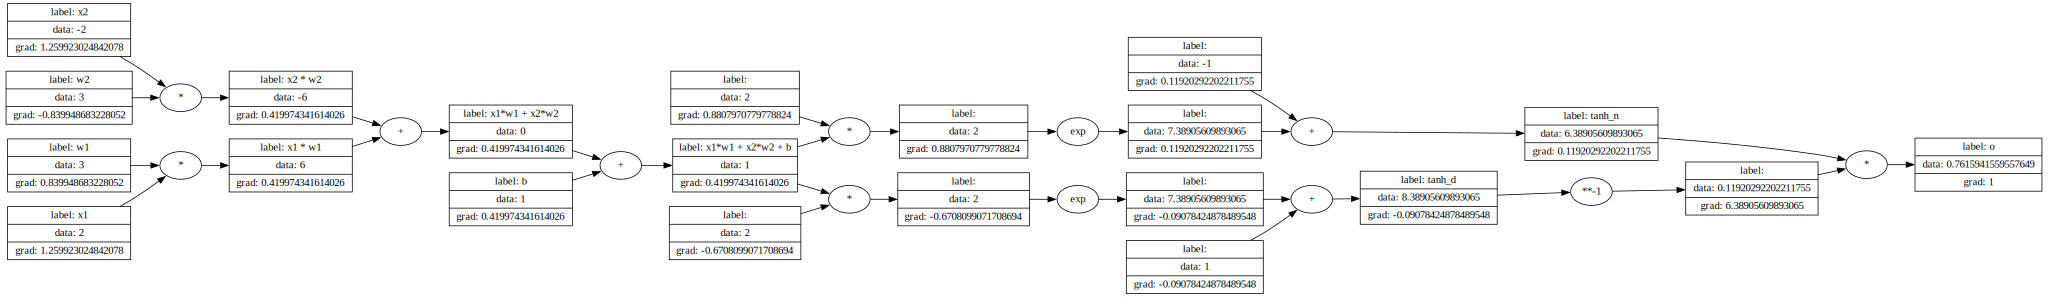

In [ ]:
o.backward()
draw_dot(o)

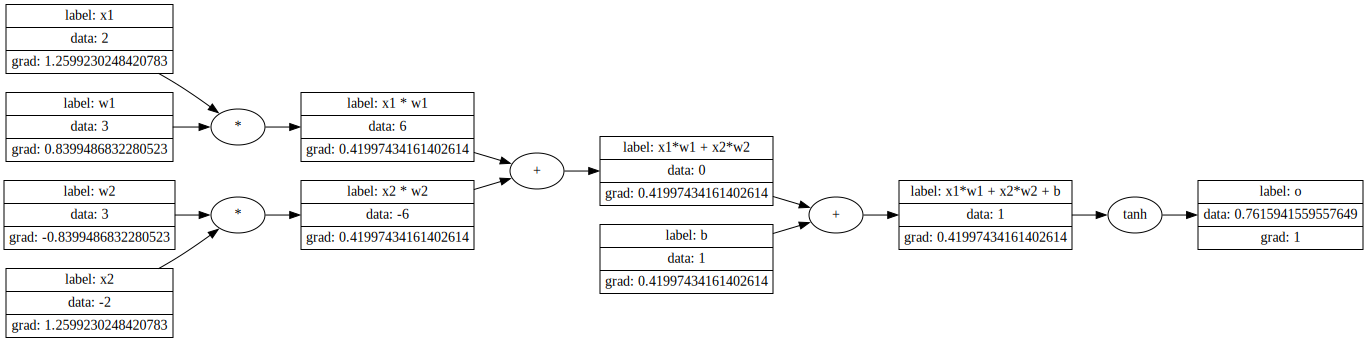

In [ ]:
x1 = Value(2, label='x1')
x2 = Value(-2, label='x2')
w1 = Value(3, label='w1')
w2 = Value(3, label='w2')
b = Value(1, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
x1w1_x2w2_b = x1w1_x2w2 + b; x1w1_x2w2_b.label = 'x1*w1 + x2*w2 + b'
o = x1w1_x2w2_b.tanh(); o.label = 'o'
o.backward()
draw_dot(o)